In [77]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#1
#1.1
#读取数据
ds = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")
#清除填充值，转换单位
fill_value = 1e20
xch4_clean = ds.xch4.where(ds.xch4 != fill_value) * 1e9
ds_clean = xr.Dataset({'xch4': xch4_clean})
#计算每月平均甲烷浓度
data = ds_clean.xch4.groupby(ds.time.dt.month).mean()
#设置图板
fig, axes = plt.subplots(4, 3, figsize=(18, 12), 
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        dpi=600)
# 计算全局最小值和最大值，后续统一图例颜色变化
vmin, vmax = data.min().item(), data.max().item()

# 循环画图
for i, ax in enumerate(axes.ravel()):
    if i < 12:  # 确保只有12个月
        # 绘制甲烷数据
        im = data.sel(month=i+1).plot(ax=ax, 
                                    vmin=vmin, 
                                    vmax=vmax,
                                    cmap='YlOrRd',
                                    add_colorbar=False, 
                                    transform=ccrs.PlateCarree())
        #添加洲界限
        ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
        #添加经纬度网格线
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray')
        #只在左边和底部的子图显示坐标轴标签
        #左边列显示经度标签
        if i % 3 == 0:  # 左边列 (0, 3, 6, 9)
            gl.left_labels = True
        else:
            gl.left_labels = False
        #底部行显示纬度标签
        if i >= 9:  #底部行 (9, 10, 11)
            gl.bottom_labels = True
        else:
            gl.bottom_labels = False
        ax.set_title(f'Month {i+1}', fontsize=12, fontweight='bold')
# 添加统一的颜色条
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Methane Concentration (ppb)', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# 设置标题
plt.suptitle('Methane Climatology for Each Month', 
             fontsize=16, fontweight='bold', y=0.95)
plt.subplots_adjust(bottom=0.15)  # 为颜色条留出空间
plt.show()

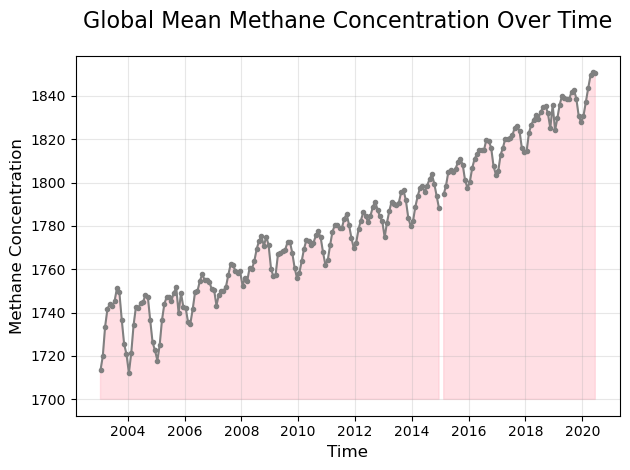

In [35]:
#1.2

def calculate_global_weighted_mean(data):
    # 计算纬度权重
    lat_weights = np.cos(np.deg2rad(data.lat))
    lat_weights = lat_weights / lat_weights.mean()
    # 处理缺失值
    data_weighted = data.weighted(lat_weights)
    global_mean = data_weighted.mean(dim=['lat', 'lon'])
    return global_mean

global_mean = calculate_global_weighted_mean(ds_clean.xch4)
#画图
global_mean.plot(linewidth=1.5,       # 线条宽度
                 color='grey',       # 线条颜色
                 linestyle='-',     # 线条样式
                 marker='o',        # 数据点标记
                 markersize=3)
plt.title('Global Mean Methane Concentration Over Time', fontsize=16, pad=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Methane Concentration', fontsize=12)
time = global_mean.time.data
mean  = global_mean.data
plt.fill_between(time, mean, 1700,  where=(mean >= 1700),
                color='pink', alpha=0.5)
#设置网格线
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

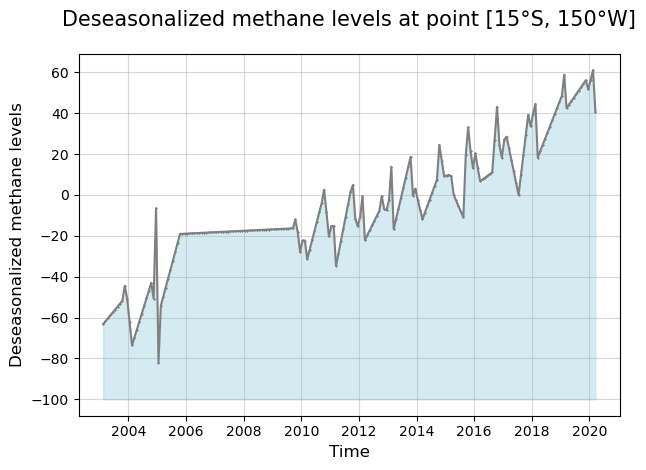

In [42]:
#1.3
#关于理解什么是“deseasonalized methane levels”，求助了deepseek
#提取点的数据
point_data = ds_clean.xch4.sel(lat=-15, lon=-150, method='nearest')
#去季节化：减去每个月的平均季节性循环，该方法来自deepseek
def deseasonalize(data):
    # 计算每个月的平均季节性循环
    seasonal_cycle = data.groupby('time.month').mean('time')
    # 从原始数据中减去季节性循环
    deseasonalized = data.groupby('time.month') - seasonal_cycle
    return deseasonalized
#应用去季节化
deseasonalized_data = deseasonalize(point_data)
#使用线性插值填充缺失值，方法来自deepseek
deseasonalized_filled = deseasonalized_data.interpolate_na(dim='time', method='linear')
#画图
deseasonalized_filled.plot(linewidth=1.5,       # 线条宽度
                 color='grey',       # 线条颜色
                 linestyle='-',     # 线条样式
                 marker='*',        # 数据点标记
                 markersize=1)
plt.title('Deseasonalized methane levels at point [15°S, 150°W]', fontsize=15, pad=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Deseasonalized methane levels', fontsize=12)
time = deseasonalized_filled.time.data
deseasonalized = deseasonalized_filled.data
plt.fill_between(time, deseasonalized , -100,  where=(deseasonalized >= -100),
                color='lightblue', alpha=0.5)
#设置网格线
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [82]:
#2
#2.1
#读取数据
noaa = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")
#筛选区域
nino = noaa.sel(lat=slice(-5,5),lon=slice(190,240))
#计算月度海表温度
nino_ts = nino.sst.mean(dim=['lat', 'lon'])
mean= nino_ts.groupby('time.month').mean()
#计算异常值
anomalies = nino_ts.groupby('time.month') - mean
anomalies


<xarray.DataArray 'sst' (time: 684)> Size: 5kB
array([-3.19578171e-01, -4.68517303e-01, -2.68152237e-01, -1.86965942e-01,
       -1.77598953e-01, -3.57694626e-01, -1.41969681e-01,  1.46522522e-02,
       -1.52212143e-01, -3.79865646e-01, -3.60893250e-01, -2.08692551e-01,
       -1.91471100e-01, -1.34279251e-01, -2.40375519e-01, -1.85125351e-01,
        5.19142151e-02,  2.39379883e-01, -7.03392029e-02, -4.18699265e-01,
       -7.78310776e-01, -7.92385101e-01, -4.96292114e-01, -4.17306900e-01,
       -4.44780350e-01, -4.55936432e-01, -4.36033249e-01, -4.66926575e-01,
       -5.64533234e-01, -4.26889420e-01, -2.76725769e-01, -3.17216873e-01,
       -6.73154831e-01, -6.66118622e-01, -8.17707062e-01, -8.65482330e-01,
       -7.01398849e-01, -3.57034683e-01,  6.96258545e-02,  1.73400879e-01,
       -9.06715393e-02,  7.69119263e-02,  6.87641144e-01,  7.95255661e-01,
        7.12984085e-01,  8.34249496e-01,  9.08538818e-01,  1.08588982e+00,
        8.51556778e-01,  5.23401260e-01, -1.30540848e-01, -6.34363174e-01,
       -8.61984253e-01, -9.45949554e-01, -7.84175873e-01, -1.09435081e+00,
       -1.25451088e+00, -1.18983650e+00, -1.29195786e+00, -1.20479202e+00,
       -7.82997131e-01, -3.68682861e-01, -1.12600327e-01, -7.66296387e-02,
        2.68373489e-01,  5.91146469e-01,  8.12013626e-01,  1.23806381e+00,
        1.27760124e+00,  1.52435303e+00,  1.58320427e+00,  1.44118500e+00,
        1.17595291e+00,  9.12752151e-01,  9.74021912e-01,  5.48082352e-01,
       -1.27168655e-01,  1.68792725e-01,  2.07981110e-01, -1.75552368e-01,
...
        2.21282959e-01, -3.75255585e-01, -8.16806793e-01, -1.19496155e+00,
       -1.42999649e+00, -1.45662689e+00, -1.37596893e+00, -1.35081673e+00,
       -1.47319603e+00, -1.05743217e+00, -8.56203079e-01, -4.86505508e-01,
       -1.43491745e-01,  4.29782867e-02, -1.12358093e-01, -3.01359177e-01,
       -5.81163406e-01, -7.46505737e-01, -9.97226715e-01, -1.00194359e+00,
       -7.01190948e-01, -5.66349030e-01, -3.01475525e-01, -1.52109146e-01,
       -8.46328735e-02,  7.59487152e-02,  1.72380447e-01,  3.80485535e-01,
        8.36549759e-01,  6.27599716e-01,  4.97859955e-01, -3.83157730e-01,
       -6.95631027e-01, -5.49224854e-01, -3.67496490e-01,  9.52854156e-02,
       -3.93390656e-02, -2.35017776e-01, -2.66674042e-01, -2.97000885e-01,
       -2.14769363e-01, -8.16001892e-02, -1.58285141e-01, -3.91712189e-01,
       -5.38034439e-01, -6.71428680e-01, -3.81156921e-01,  2.24323273e-02,
        3.64341736e-01,  2.08314896e-01,  8.80393982e-02, -1.84249878e-03,
        2.54852295e-01,  5.18690109e-01,  8.60204697e-01,  7.23592758e-01,
        6.23180389e-01,  5.44246674e-01,  5.93399048e-01,  9.04596329e-01,
        1.00379372e+00,  1.14265442e+00,  1.40406609e+00,  1.65552521e+00,
        1.91476822e+00,  2.32380486e+00,  2.70230293e+00,  2.52171898e+00,
        2.46178818e+00,  2.14287376e+00,  1.61798477e+00,  1.15098190e+00,
        4.64086533e-01, -1.12241745e-01, -5.67394257e-01, -6.47750854e-01,
       -6.40016556e-01, -8.96677017e-01, -9.70773697e-01, -8.55255127e-01])
Coordinates:
  * time     (time) datetime64[ns] 5kB 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 5kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

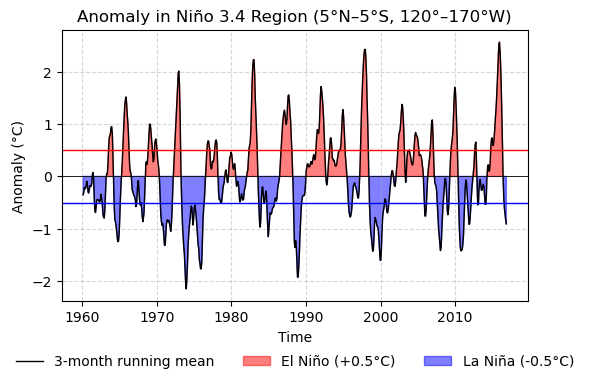

In [83]:
#2.2
#计算3个月滑动平均，来自kimi
anom = anomalies.rolling(time=3, center=True).mean()
time = anom.time.data
sst  = anom.data
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(anom.time.data, anom.data, color='black', lw=1, label='3-month running mean')
#加阈值线
ax.axhline(0.5, color='red', lw=1, ls='-')
ax.axhline(-0.5, color='blue', lw=1, ls='-')
ax.axhline(0, color='black', lw=0.6)
#填充,来自kimi
ax.fill_between(time, sst, 0,  where=(sst >= 0),
                color='red', alpha=0.5, label='El Niño (+0.5°C)')
ax.fill_between(time, sst, 0, where=(sst <= 0),
                color='blue', alpha=0.5, label='La Niña (-0.5°C)')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=3, frameon=False)
ax.set_ylabel('Anomaly (°C)')
ax.set_xlabel('Time')
ax.set_title('Anomaly in Niño 3.4 Region (5°N–5°S, 120°–170°W)')
ax.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

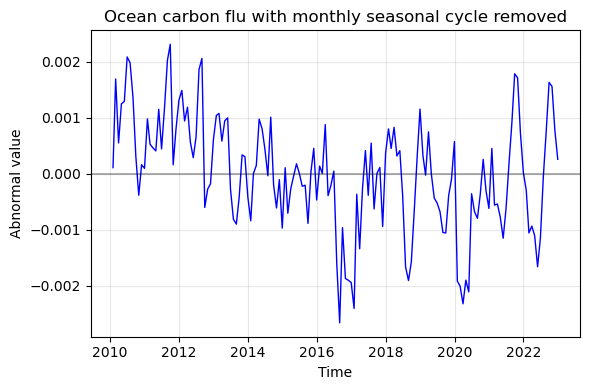

In [72]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
#3 下载了Carbon Monitoring System Carbon Flux Ocean数据，从2010年到2022年的月度数据
car = xr.open_dataset("CMSFluxOcean201001_202212_v3.nc", engine="netcdf4",decode_times=False)
#将car.time转化成常规年月，来自deepseek
dates = pd.date_range('2010-01-01', periods=156, freq='M')  
car['time'] = dates

# 3.1 绘制去除月度季节循环的时间序列
# 计算全球平均（对经纬度求平均）
flux_global = car['ocean_post'].mean(dim=['longitude', 'latitude'])
#计算月度气候平均（季节循环）
seasonal_cycle = flux_global.groupby('time.month').mean()
#从原始数据中减去季节循环，得到异常值
anomaly = flux_global.groupby('time.month') - seasonal_cycle
#画图
plt.figure(figsize=(6, 4))
plt.plot(anomaly.time, anomaly, 'b-', linewidth=1)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Ocean carbon flu with monthly seasonal cycle removed')
plt.ylabel('Abnormal value')
plt.xlabel('Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

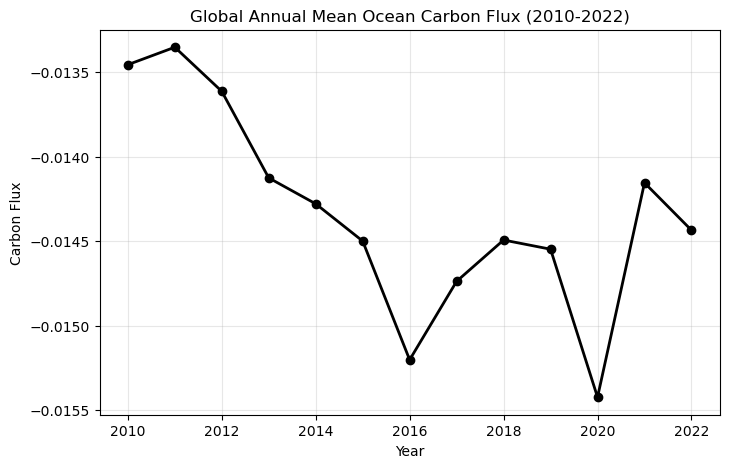

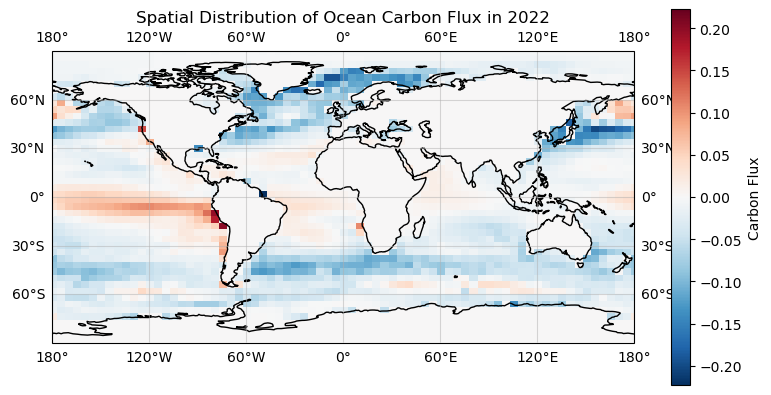

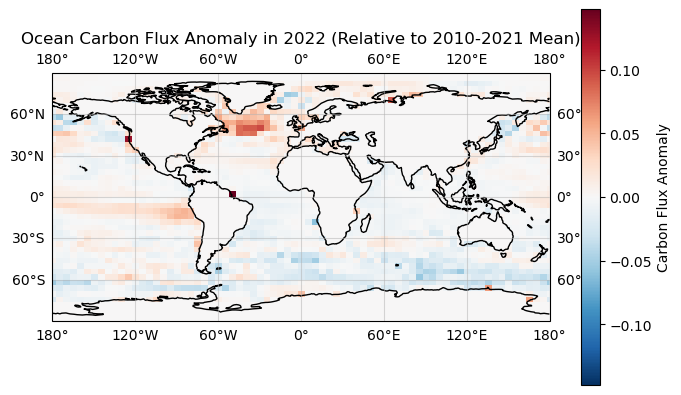

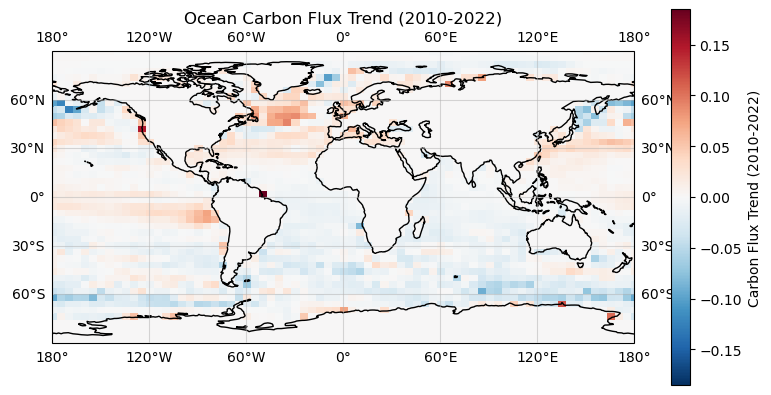

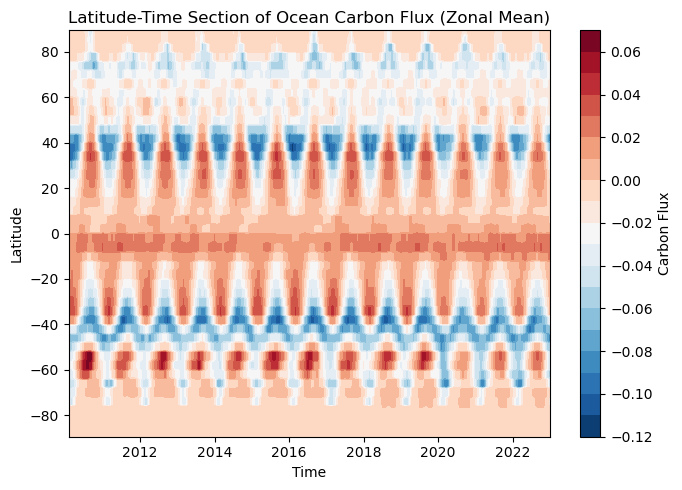

In [84]:
# 3.2
#图1:全球年平均碳通量时间序列
plt.figure(figsize=(8, 5))
annual_mean = car['ocean_post'].groupby('time.year').mean(dim=['longitude', 'latitude', 'time'])
plt.plot(annual_mean.year, annual_mean, 'o-', linewidth=2, markersize=6, color='black')
plt.title('Global Annual Mean Ocean Carbon Flux (2010-2022)')
plt.ylabel('Carbon Flux')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.show()

#图2:2022年全球空间分布
plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
#选择2022年数据
recent_data = car['ocean_post'].sel(time=car.time[car.time.dt.year == 2022]).mean(dim='time')
im = recent_data.plot(ax=ax, transform=ccrs.PlateCarree(), 
                     cmap='RdBu_r', 
                     cbar_kwargs={'shrink': 0.8, 'label': 'Carbon Flux'})
#添加洲界限
ax.coastlines()
ax.gridlines(draw_labels=True, alpha=0.5)
ax.set_title('Spatial Distribution of Ocean Carbon Flux in 2022')
plt.tight_layout()
plt.show()

#图3:碳通量异常空间分布（2022年相对于2010-2021年平均）
#计算2010-2021年气候平均
climatology = car['ocean_post'].sel(time=car.time[car.time.dt.year < 2022]).mean(dim='time')
#计算2022年平均
recent_year = car['ocean_post'].sel(time=car.time[car.time.dt.year == 2022]).mean(dim='time')
#计算异常
anomaly_spatial = recent_year - climatology
plt.figure(figsize=(7, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
im = anomaly_spatial.plot(ax=ax, transform=ccrs.PlateCarree(), 
                        cmap='RdBu_r', center=0,
                        cbar_kwargs={'shrink': 0.8, 'label': 'Carbon Flux Anomaly'})
ax.coastlines()
ax.gridlines(draw_labels=True, alpha=0.5)
ax.set_title('Ocean Carbon Flux Anomaly in 2022 (Relative to 2010-2021 Mean)')
plt.tight_layout()
plt.show()

#图4:碳通量变化趋势空间分布 (2010-2022)
def calc_trend(ts):
    """计算时间序列的线性趋势"""
    if np.isnan(ts).all():
        return np.nan
    x = np.arange(len(ts))
    mask = ~np.isnan(ts)
    if mask.sum() < 2:  # 至少需要2个有效点
        return np.nan
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], ts[mask])
    return slope * len(ts)  # 返回整个时间段的趋势
# 应用趋势计算
trend_data = xr.apply_ufunc(
    calc_trend,
    car['ocean_post'],
    input_core_dims=[['time']],
    output_core_dims=[[]],
    vectorize=True
)
plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
im = trend_data.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    cmap='RdBu_r', center=0,
                    cbar_kwargs={'shrink': 0.8, 'label': 'Carbon Flux Trend (2010-2022)'})
ax.coastlines()
ax.gridlines(draw_labels=True, alpha=0.5)
ax.set_title('Ocean Carbon Flux Trend (2010-2022)')
plt.tight_layout()
plt.show()

# 图5:碳通量纬度-时间剖面（经度平均）
plt.figure(figsize=(7, 5))
zonal_mean = car['ocean_post'].mean(dim='longitude')
contour = plt.contourf(car.time.dt.year + car.time.dt.month/12, 
                      car.latitude, zonal_mean.T, 
                      levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Carbon Flux')
plt.xlabel('Time')
plt.ylabel('Latitude')
plt.title('Latitude-Time Section of Ocean Carbon Flux (Zonal Mean)')
plt.tight_layout()
plt.show()